#[HAICon] PRIVATE 14위, datu

- 소속 : 한국외국어대학교 글로벌캠퍼스 산업경영공학과
- 관심분야 : cv, natural language

# 최종 모델 

## 1. Model 구성 
1. StackedGRU by bidirectional
2. MSE Loss + AdamW 

## 2. 최종 성능최적화 방법
1. Model의 ouput에 lowpass filter를 적용해 noise를 제거 (데이터후처리)
2. shingle size와 stride 튜닝                           (데이터전처리)
3. epoch 튜닝                                           (모델 hyper-parameter 조정)
4. Threshold 조정                                       (모델 hyper-parameter 조정)
5. model selection by grid-search

## 3. 모델 선정 기준
1. 일반화 성능이 높은 모델 (Test data' TaPR과 Public score의 차이가 적은 모델)으로 선정하려 했으나 public 점수가 높게 나오지 않아 TaR이 크면서 Tap가 많이 낮지 않은 것으로 선정
2. public score가 높은 모델 

## 4. 최종 모델 성능
- Test data TaPR : F1: 0.399 (TaP: 0.265, TaR: 0.803)
- Publice score : 0.5249507184
- Private score : 0.52178
- 최종 모델 경로 : 첨부 파일의 /content/drive/MyDrive/HAIcon/2021_HAI/final_model_shingle52_epoch70.pt


## 5. Path 정보

- Data Path
    1. traing data : /content/drive/MyDrive/HAIcon/2021_HAI/train/
    2. validation data : /content/drive/MyDrive/HAIcon/2021_HAI/validation/
    3. test data : /content/drive/MyDrive/HAIcon/2021_HAI/test/
    
    
- Model Path
    1. model 저장 경로 : /content/drive/MyDrive/HAIcon/2021_HAI/{model_name}.pt
    2. 최종제출 model : /content/drive/MyDrive/HAIcon/2021_HAI/final_model_shingle52_epoch70.pt
    
    
- Submission Path
    1. submission 저장 경로 : /content/drive/MyDrive/HAIcon/2021_HAI/
    2. sample path : /content/drive/MyDrive/HAIcon/2021_HAI/sample_submission.csv
    3. 최종제출 submisstion : /content/drive/MyDrive/HAIcon/2021_HAI/final_submission_52_70_399.csv
    
    
- TaPR Lib path
    1. whl file : /content/drive/MyDrive/HAIcon/eTaPR-1.12-py3-none-any.whl
    
## 6. Library 버전
colab 환경에서 돌림



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MODULE

In [ ]:
!pip install /content/drive/MyDrive/HAIcon/eTaPR-1.12-py3-none-any.whl

Processing ./drive/MyDrive/HAIcon/eTaPR-1.12-py3-none-any.whl


In [ ]:
path = '/content/drive/MyDrive/HAIcon/2021_HAI/'

In [ ]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange

import numpy as np
import pandas as pd

import sys
from TaPR_pkg import etapr

In [ ]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

## DATA PREPROCESSING

- 제공된 csv 데이터를 읽어 오는 작업을 진행합니다. 

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())
def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
train_list = sorted([x for x in Path(path + "train/").glob("*.csv")])
validation_list = sorted([x for x in Path(path + "validation/").glob("*.csv")])
test_list = sorted([x for x in Path(path + "test/").glob("*.csv")])

pdf = dataframe_from_csvs(train_list)
pdf_validation = dataframe_from_csvs(validation_list)
pdf_test = dataframe_from_csvs(test_list)

In [ ]:
pdf.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1004402.0,1004402.0,1.004402e+06,...,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06
mean,-2.068788e+00,0.0,1.224465e+01,-3.072510e-05,6.507154e+01,4.457734e-01,1.259976e+01,7.448029e+01,1.0,50.0,1.469380e+04,1.554154e+01,2.803526e+01,2.721090e+04,2.814440e+01,3.414727e+01,8.009442e-02,1.0,50.0,2.741724e+01,3.142758e+01,1.0,3.311973e+02,4.494780e+02,7.812006e+02,50.0,1.807884e+04,1.105594e+00,1.0,5.470553e+04,1.009975e+03,6.443072e+01,6.063227e+00,8.009542e-02,1.135242e+02,2880.0,3.009478e+01,0.0,0.0,1.633104e+03,...,3.270781e+01,9.199046e-01,0.0,4.821710e+03,3.884629e+01,1.0,3.519280e+01,4.380170e-01,0.0,3.309293e+02,4.486695e+02,1.430943e+01,5.066348e+01,7.200588e+02,9.199056e-01,8.992095e+02,0.0,8.009442e-02,7.593735e+03,1.233080e-01,6.914063e+01,9.972942e+03,1.0,3.354519e+02,3.212631e+01,6.496662e+01,2.530646e+02,2.202218e+03,3.472195e+01,5.007517e+01,1.105578e+00,3.386906e+01,4.192900e+00,2.202201e+03,3.662623e+02,1.0,1.009977e+03,1.200010e+01,50.0,1.126177e+03
std,9.973782e-01,0.0,1.322091e-01,1.644198e-03,4.124122e+01,9.490236e-01,2.312396e-01,4.972919e+00,0.0,0.0,4.239379e+03,2.624286e+00,4.702160e-03,1.056617e+02,6.865891e-01,4.697763e+00,2.714395e-01,0.0,0.0,2.435843e-01,1.086141e+00,0.0,3.275944e+01,3.093692e+01,1.312306e+03,0.0,1.773992e+03,1.044498e-01,0.0,1.400807e+02,3.998495e+01,8.033772e+00,1.101537e+00,2.714410e-01,8.377750e+00,0.0,2.886617e+00,0.0,0.0,1.130341e+03,...,3.340571e+01,2.714410e-01,0.0,5.027135e+03,3.621956e+00,0.0,3.132628e+01,2.284484e-01,0.0,3.629854e+01,3.038842e+01,1.319813e+01,3.026659e+00,7.449546e-02,2.714395e-01,2.685508e+01,0.0,2.714395e-01,6.809536e+03,4.335728e-02,4.188169e+01,2.536939e+01,0.0,4.156542e+01,8.066558e+00,4.091532e+01,2.134891e+01,1.329766e+03,4.775040e+00,2.947610e+00,8.886521e-02,2.897106e+00,3.445795e+00,1.329775e+03,6.061224e+01,0.0,3.981555e+01,1.718555e-02,0.0,1.693609e+03
min,-4.627100e+00,0.0,1.198730e+01,-4.253000e-02,2.685500e-01,-2.146700e+00,1.203892e+01,7.000000e+01,1.0,50.0,4.705000e+03,2.609300e-01,2.801602e+01,2.686600e+04,2.615353e+01,1.207794e+01,0.000000e+00,1.0,50.0,2.700000e+01,2.789917e+01,1.0,2.330910e+02,3.732661e+02,-3.800000e+01,50.0,1.285100e+04,7.719300e-01,1.0,5.415700e+04,8.639604e+02,4.196300e-01,3.422700e+00,0.000000e+00,1.001277e+02,2880.0,2.518253e+01,0.0,0.0,2.136250e+00,...,1.233826e+01,0.000000e+00,0.0,-8.000000e+00,3.446044e+01,1.0,9.042000e-02,3.076200e-01,0.0,2.303603e+02,3.921769e+02,0.000000e+00,4.369507e+01,7.195103e+02,0.000000e+00,7.920000e+02,0.0,0.000000e+00,-1.280000e+02,5.498000e-02,0.000000e+00,9.826000e+03,1.0,2.184900e+00,0.000000e+00,0.000000e+00,1.863861e+02,1.112275e+01,1.281891e+01,4.330319e+01,5.532800e-01,2.815872e+01,0.000000e+00,1.112275e+01,2.309570e+02,1.0,8.900452e+02,1.200000e+01,50.0,-1.120000e+

#### 1) Featur Scaling
Min-Max scaling

In [ ]:
TRAIN_DF_RAW = pdf
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"

#VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD,'C03','C14','C18','C19','C21','C25','C33','C34','C35','C37','C43','C51','C52','C59','C61','C63','C64','C65','C67'])
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min() # To get min value on each columns
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max() # To get max value on each columns
def normalize(df): # implement min-max scaler
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
def boundary_check(df):  # Implement boundary-check function
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

#### 2) Feature noise 제거

ewm 적용하여 noise 제거

----------------------------------
#### 최종 hyper-parameter 선정 
- ewm' alpha : 0.9


In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,0.390156,0.501876,0.520480,0.449040,0.252360,0.193673,0.0,0.0,0.0,0.305026,0.452537,0.0,0.133292,0.578120,0.626384,0.0,0.135313,0.132221,0.0,0.976296,0.513118,0.259863,0.369939,0.0,0.900937,0.0,0.209725,0.0,0.0,0.029799,...,0.424797,1.0,0.0,0.994220,0.471624,0.0,0.000575,0.130348,0.0,0.172978,0.798452,0.178051,0.241962,0.465834,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.150771,0.207547,0.0,0.321628,0.805819,0.155046,0.443864,0.138395,0.191217,0.246855,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,0.397402,0.502077,0.403097,0.450383,0.252360,0.193649,0.0,0.0,0.0,0.305026,0.450531,0.0,0.136943,0.576120,0.631199,0.0,0.137850,0.133443,0.0,0.976296,0.519266,0.256744,0.245047,0.0,0.900937,0.0,0.209725,0.0,0.0,0.028294,...,0.443542,1.0,0.0,0.994220,0.471624,0.0,0.000575,0.101569,0.0,0.181368,0.798452,0.178051,0.241962,0.596204,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.149815,0.207547,0.0,0.318762,0.805581,0.161370,0.439117,0.125047,0.191217,0.248731,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,0.403379,0.502095,0.467897,0.449173,0.252360,0.193558,0.0,0.0,0.0,0.305026,0.450351,0.0,0.140079,0.575940,0.630765,0.0,0.141302,0.135839,0.0,0.976296,0.515758,0.261871,0.363195,0.0,0.900937,0.0,0.209725,0.0,0.0,0.029108,...,0.447321,1.0,0.0,0.994740,0.471624,0.0,0.000575,0.094505,0.0,0.182062,0.798452,0.178051,0.241962,0.478753,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.149092,0.207547,0.0,0.314716,0.805323,0.164942,0.435161,0.117652,0.191315,0.246604,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,0.408887,0.502096,0.475662,0.450383,0.252360,0.193846,0.0,0.0,0.0,0.305026,0.450333,0.0,0.146871,0.572809,0.628411,0.0,0.147183,0.140053,0.0,0.976296,0.512176,0.263923,0.313719,0.0,0.900937,0.0,0.209725,0.0,0.0,0.031288,...,0.432270,1.0,0.0,0.994792,0.471624,0.0,0.000575,0.099950,0.0,0.187506,0.798452,0.178051,0.241962,0.499620,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.148311,0.207547,0.0,0.320938,0.805061,0.163216,0.438294,0.120857,0.191227,0.249111,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,0.415910,0.502097,0.476437,0.450504,0.252360,0.193843,0.0,0.0,0.0,0.305026,0.452317,0.0,0.151538,0.573911,0.627454,0.0,0.152922,0.140232,0.0,0.974963,0.515053,0.262584,0.308776,0.0,0.900937,0.0,0.209725,0.0,0.0,0.033876,...,0.410120,1.0,0.0,0.994797,0.471624,0.0,0.000575,0.117812,0.0,0.198128,0.798452,0.178051,0.241962,0.501704,1.0,0.909722,0.0,0.0,0.007323,0.22613,0.147409,0.207547,0.0,0.323451,0.804799,0.158453,0.437432,0.129893,0.191218,0.251851,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,0.213613,0.381810,0.459083,0.511453,0.371984,0.370597,0.0,0.0,0.0,0.752517,0.507725,0.0,0.326726,0.565976,0.006420,0.0,0.318660,0.368856,0.0,0.863704,0.452023,0.262573,0.404346,0.0,0.413326,0.0,0.748145,0.0,0.0,0.976893,...,0.000714,1.0,0.0,0.000578,0.124171,0.0,0.68258



- "C02", 'C09', 'C10', 'C18', 'C19', 'C22', 'C26', 'C29', 'C34', 'C36', 'C38', 'C39', 'C49', 'C52', 'C55', 'C63', 'C64', 'C69', 'C82', 'C84', 'C85'

In [ ]:
TRAIN_DF.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1004402.0,1004402.0,1.004402e+06,...,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06,1.004402e+06,1004402.0,1.004402e+06
mean,4.689247e-01,0.0,5.278706e-02,5.117928e-01,6.441084e-01,4.895708e-01,7.260389e-01,4.480288e-01,0.0,0.0,5.568204e-01,4.420350e-01,4.805930e-01,5.094487e-01,4.616315e-01,3.201560e-01,8.009442e-02,0.0,0.0,4.422457e-01,5.104590e-01,0.0,3.756326e-01,4.686994e-01,1.314718e-01,0.0,3.740849e-01,3.900405e-01,0.0,8.126308e-01,5.160247e-01,2.878237e-01,4.624067e-01,8.009542e-02,4.503195e-01,0.0,5.920433e-01,0.0,0.0,6.434621e-01,...,2.383182e-01,9.199046e-01,0.0,3.489676e-01,2.812433e-01,0.0,3.724140e-01,1.060923e-01,0.0,3.773795e-01,5.332380e-01,2.861885e-01,3.027391e-01,5.603719e-01,9.199056e-01,7.445102e-01,0.0,8.009442e-02,3.926838e-01,4.720739e-01,6.914062e-01,3.465613e-01,0.0,3.527244e-01,9.178944e-01,6.496661e-01,4.563804e-01,6.892669e-01,3.144097e-01,2.985862e-01,3.597938e-01,5.770209e-01,4.192900e-01,6.892614e-01,5.033529e-01,0.0,5.173684e-01,1.871145e-05,0.0,9.448133e-02
std,1.816325e-01,0.0,2.711736e-02,1.849803e-02,4.099142e-01,1.789313e-01,2.993505e-01,4.972917e-01,0.0,0.0,2.363175e-01,7.590298e-02,1.126587e-01,1.560596e-01,1.591929e-01,6.814898e-02,2.714361e-01,0.0,0.0,2.581816e-01,1.571319e-01,0.0,1.254172e-01,1.902598e-01,2.105272e-01,0.0,1.269231e-01,1.220844e-01,0.0,2.075257e-01,1.412957e-01,3.610861e-02,1.917853e-01,2.714377e-01,2.816137e-01,0.0,3.479060e-01,0.0,0.0,4.459473e-01,...,3.908300e-01,2.714377e-01,0.0,3.631968e-01,2.322583e-01,0.0,3.323141e-01,1.858230e-01,0.0,1.361663e-01,2.868380e-01,2.639609e-01,1.314794e-01,7.246362e-02,2.714361e-01,1.864767e-01,0.0,2.714361e-01,3.462591e-01,2.995527e-01,4.188168e-01,5.978501e-02,0.0,4.397380e-02,2.304715e-01,4.091513e-01,1.461112e-01,4.183055e-01,6.853947e-02,1.299605e-01,5.788084e-02,2.927475e-01,3.445783e-01,4.183084e-01,2.254592e-01,0.0,1.717591e-01,3.333650e-03,0.0,1.291178e-01
min,7.951789e-03,0.0,1.565067e-04,5.181067e-02,1.516766e-05,8.401645e-04,0.000000e+00,0.000000e+00,0.0,0.0,2.247562e-04,4.411495e-05,4.643382e-02,2.277656e-04,1.442858e-301,5.558370e-04,0.000000e+00,0.0,0.0,0.000000e+00,2.008994e-04,0.0,3.195172e-04,9.495737e-05,1.547908e-03,0.0,8.620651e-04,5.113238e-04,0.0,0.000000e+00,6.886625e-05,2.658585e-04,1.386976e-02,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,9.220850e-05,...,1.962637e-05,0.000000e+00,0.0,5.728324e-06,9.777582e-05,0.0,5.753460e-07,5.377667e-04,0.0,7.638681e-04,0.000000e+00,0.000000e+00,4.365269e-05,5.438629e-03,0.000000e+00,4.854168e-03,0.0,0.000000e+00,8.136689e-05,0.000000e+00,0.000000e+00,1.676462e-03,0.0,3.258180e-04,0.000000e+00,0.000000e+00,5.849880e-05,3.828065e-04,5.898816e-05,3.536042e-04,3.931927e-04,6.443158e-05,0.000000e+00,3.828065e-04,4.992635e-04,0.0,0.000000e+00,0.000000e+00,0.0,9.004197e-04
25%,3.573124e-01,0.

In [ ]:
 boundary_check(TRAIN_DF) # check whether feature doesn't over boundary

(False, False, False)

### 3) 데이터 Augmentation


----------------------------------
#### 최종 hyper-parameter 선정 
 - shingle size : 52
 - stride : 1 


In [ ]:
WINDOW_GIVEN = 51
WINDOW_SIZE = 52

In [ ]:
# refer dacon's example code 
class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [ ]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004351 [00:00<?, ?it/s]

# of valid windows: 1004096


{'answer': tensor([3.8767e-01, 0.0000e+00, 5.6212e-02, 4.9367e-01, 1.4583e-01, 3.9851e-01,
         8.1607e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7943e-01, 6.2216e-01,
         5.4620e-01, 4.4651e-01, 2.5236e-01, 2.4010e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.0503e-01, 4.3514e-01, 0.0000e+00, 3.3689e-01, 5.7711e-01,
         5.8240e-01, 0.0000e+00, 3.4915e-01, 3.1983e-01, 0.0000e+00, 9.7628e-01,
         5.2758e-01, 3.2285e-01, 2.4474e-01, 0.0000e+00, 9.0094e-01, 0.0000e+00,
         2.0972e-01, 0.0000e+00, 0.0000e+00, 2.4776e-02, 1.8029e-01, 5.2425e-01,
         6.3438e-01, 4.2862e-01, 4.0865e-03, 1.0000e+00, 5.2152e-01, 1.0000e+00,
         0.0000e+00, 9.9884e-01, 4.7260e-01, 0.0000e+00, 5.7535e-04, 5.0361e-02,
         0.0000e+00, 4.0831e-01, 7.9845e-01, 1.7805e-01, 2.5721e-01, 5.2853e-01,
         1.0000e+00, 9.0278e-01, 0.0000e+00, 0.0000e+00, 7.3230e-03, 2.2613e-01,
         1.2281e-01, 1.5302e-01, 0.0000e+00, 3.9040e-01, 7.9246e-01, 1.5803e-01,
         4.5181e-0

## 모델 구조 설정

#### Bidirectional StackedGRU를 활용해 구현
#### 데이터 후처리, 데이터 전처리, hyper-parameter 튜닝으로 일반화성능이 뛰어난 모델을 최적화하고자 했습니다.


----------------------------------
#### 최종 hyper-parameter 선정

 - Hidden cells : 100
 - layer : 3
 - batch size : 512
 - dropout : 0 
 

In [ ]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS*2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [ ]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(86, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=86, bias=True)
)

In [ ]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  
    optimizer = torch.optim.AdamW(model.parameters()) # optimizer is admaw
    loss_fn = torch.nn.MSELoss() # loss is mseloss 
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")

    return best, loss_history

## 모델 학습 및 결과검토

----------------------------------
#### 최종 hyper-parameter 선정

- EPOCH : 70
- 선정이유 : shingle size 40일때, epoch 70미만은 underfitting이 확인됐으며, 70을 초과하는 모델들에서는 overfitting이 확인됐습니다. tuning을 통해 70이 가장 적합하다고 판단했습니다. 

In [ ]:
EPOCH = 70
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, EPOCH)

training:   0%|          | 0/70 [00:00<?, ?it/s]

가장 성능이 좋았던 모델을 저장합니다. 

## Model selection by grid-search
#### 또한, 동일한 hyper-parameter를 갖는 경우에도 학습을 할 때마다 model이 변경됩니다. 즉, weight같은 parameter값이 변경되기 때문에 동일한 hyper-parameter 조건하에 여러 개의 모델을 만든 후에 그 중 가장 public score가 높은 모델을 최종 selection 했습니다.

In [ ]:
with open(path + "final_model_single52_epoch70.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

최종 학습된 모델을 불러와, 모델의 loss 지표를 확인

In [ ]:
with open(path + "final_model_single52_epoch70.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

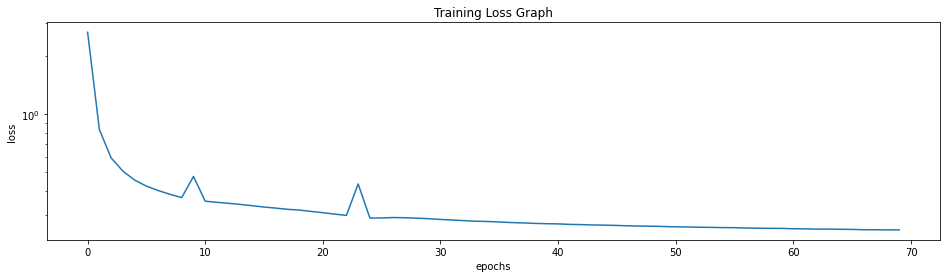

In [ ]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

## 모델 검증 진행


In [ ]:
VALIDATION_DF_RAW = dataframe_from_csvs(validation_list)
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
VALIDATION_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.474293,0.0,-0.040688,0.519147,0.159551,0.481116,1.119160,0.0,0.0,0.0,0.311277,0.330391,0.476523,0.465288,0.391755,0.252807,0.0,0.0,0.0,0.843921,0.454746,0.0,0.388589,0.397988,0.006580,0.0,0.377818,0.317642,0.0,0.997037,0.595393,0.255575,0.273939,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032358,...,0.415335,1.0,0.0,0.000578,0.697652,0.0,0.760553,0.115451,0.0,0.234528,0.369551,0.419792,0.328804,0.529181,1.0,0.937500,0.0,0.0,0.778682,0.030846,0.149131,0.410377,0.0,0.315322,1.000000,0.150976,0.531332,0.134334,0.259555,0.323196,0.437871,0.339753,0.071604,0.118089,0.467573,0.0,0.624077,0.0,0.0,0.020832
1,0.451714,0.0,-0.040688,0.481925,0.156242,0.484154,1.119160,0.0,0.0,0.0,0.310112,0.330391,0.455862,0.455888,0.391755,0.251640,0.0,0.0,0.0,0.843921,0.454746,0.0,0.382986,0.395988,0.006434,0.0,0.376517,0.316059,0.0,0.995690,0.595393,0.254795,0.323895,0.0,0.990896,0.0,0.307856,0.0,0.0,0.034273,...,0.412657,1.0,0.0,0.000578,0.697652,0.0,0.784798,0.113757,0.0,0.244645,0.369551,0.419792,0.328804,0.367179,1.0,0.931187,0.0,0.0,0.734300,0.030846,0.149516,0.408233,0.0,0.313411,1.000000,0.147496,0.531332,0.142286,0.259356,0.323562,0.437871,0.339437,0.071604,0.125189,0.452160,0.0,0.624077,0.0,0.0,0.020416
2,0.381911,0.0,-0.042098,0.465987,0.145560,0.424951,1.119160,0.0,0.0,0.0,0.308600,0.330391,0.456251,0.452380,0.391755,0.250245,0.0,0.0,0.0,0.843921,0.454746,0.0,0.379675,0.392975,0.006421,0.0,0.375690,0.312788,0.0,0.994234,0.593362,0.253179,0.204819,0.0,0.990896,0.0,0.307856,0.0,0.0,0.033497,...,0.425765,1.0,0.0,0.000578,0.697652,0.0,0.751202,0.107455,0.0,0.259740,0.369551,0.419792,0.328804,0.417238,1.0,0.936874,0.0,0.0,0.645269,0.030846,0.149880,0.408040,0.0,0.312292,1.000000,0.143511,0.528979,0.139062,0.255392,0.323957,0.431603,0.338055,0.071604,0.133427,0.435862,0.0,0.624077,0.0,0.0,0.019966
3,0.393676,0.0,-0.040829,0.491074,0.143888,0.463538,1.119160,0.0,0.0,0.0,0.307297,0.330391,0.514062,0.446715,0.391755,0.249438,0.0,0.0,0.0,0.843921,0.454746,0.0,0.375233,0.392960,0.006420,0.0,0.369168,0.305120,0.0,0.995424,0.597218,0.253019,0.342219,0.0,0.990896,0.0,0.307856,0.0,0.0,0.032200,...,0.446827,1.0,0.0,0.001098,0.697652,0.0,0.641840,0.096220,0.0,0.268259,0.369551,0.419792,0.328804,0.519174,1.0,0.918686,0.0,0.0,0.614483,0.030846,0.150110,0.408021,0.0,0.310289,1.000000,0.145296,0.533446,0.133681,0.248395,0.325421,0.423829,0.335802,0.071604,0.142116,0.409784,0.0,0.624077,0.0,0.0,0.019852
4,0.434492,0.0,-0.042110,0.517858,0.144267,0.447745,1.119160,0.0,0.0,0.0,0.300644,0.330391,0.363393,0.451466,0.391755,0.248570,0.0,0.0,0.0,0.843921,0.454746,0.0,0.368121,0.392676,0.006420,0.0,0.358985,0.301461,0.0,0.996876,0.592532,0.249144,0.217407,0.0,0.990896,0.0,0.307856,0.0,0.0,0.030513,...,0.469176,1.0,0.0,0.045370,0.697652,0.0,0.610193,0.080569,0.0,0.279004,0.369551,0.419792,0.324329,0.528907,1.0,0.935619,0.0,0.0,0.556484,0.030846,0.150440,0.408019,0.0,0.310089,1.000000,0.151731,0.528018,0.126677,0.247499,0.323904,0.424389,0.335577,0.071604,0.139048,0.389922,0.0,0.624077,0.0,0.0,0.019841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.330458,0.0,0.056340,0.526499,0.151740,0.395722,0.816071,0.0,0.0,0.0,0.099732,0.409600,0.285391,0.590096,0.396085,0.373037,0.0,0.0,0.0,0.843921,0.591612,0.0,0.466913,0.507561,0.006580,0.0,0.457939,0.549062,0.0,0.844430,0.557727,0.312699,0.322156,0.0,0.329096,0.0,0.315971,0.0,0.0,0.132362,...,0.073338,1.0,0.0,0.001156,0.345206,0.

In [ ]:
VALIDATION_DF.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
count,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.0,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.0,8.640000e+04,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.000000,86400.0,86400.0,86400.000000,...,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.0,8.640000e+04,86400.000000,86400.0,86400.000000,86400.000000,8.640000e+04,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,8.640000e+04,86400.000000,86400.000000,86400.0,86400.000000,86400.000000,86400.0,86400.000000
mean,0.397315,0.0,-0.010617,0.511837,0.155582,0.437582,0.912035,0.0,0.0,0.0,0.491130,0.428430,0.456733,0.531976,0.459589,0.265185,0.081123,0.0,0.0,8.439208e-01,0.532220,0.0,0.383741,0.471325,0.132444,0.0,0.381765,0.400893,0.0,0.835786,0.496644,0.283882,0.292367,0.081123,0.544064,0.0,0.310026,0.0,0.0,0.095617,...,0.485564,0.918877,0.0,0.352721,0.529984,0.0,3.456875e-01,0.215241,0.0,0.385314,0.538077,4.197919e-01,0.271945,0.496294,0.918877,0.784635,0.0,0.081123,0.364974,0.496070,0.214552,0.352305,0.0,0.347766,0.864752,0.161711,0.432138,0.211755,0.258815,0.268865,0.365749,0.342534,7.160420e-02,0.211745,0.501816,0.0,0.493694,0.000228,0.0,0.093761
std,0.059105,0.0,0.045959,0.018408,0.100942,0.035091,0.140985,0.0,0.0,0.0,0.224081,0.082709,0.078489,0.076386,0.142028,0.048030,0.273021,0.0,0.0,3.297381e-14,0.077196,0.0,0.133053,0.196615,0.212542,0.0,0.133808,0.131007,0.0,0.200943,0.097443,0.039523,0.062903,0.273021,0.255740,0.0,0.003591,0.0,0.0,0.194623,...,0.327930,0.273021,0.0,0.368794,0.207779,0.0,3.325125e-01,0.227925,0.0,0.142780,0.292353,1.458841e-13,0.065744,0.067889,0.273021,0.178921,0.0,0.273021,0.346577,0.302399,0.210737,0.072196,0.0,0.046134,0.231669,0.100291,0.094927,0.209836,0.048241,0.062920,0.071170,0.034352,1.340047e-13,0.209803,0.219834,0.0,0.117485,0.011092,0.0,0.129266
min,0.247220,0.0,-0.045070,0.373108,0.000387,0.311288,0.816071,0.0,0.0,0.0,0.074496,0.000664,0.153678,0.317421,0.239765,0.001273,0.000000,0.0,0.0,8.439208e-01,0.326709,0.0,0.022099,-0.420188,0.006259,0.0,0.015760,0.011447,0.0,0.189630,0.007467,0.001715,0.135091,0.000000,0.006066,0.0,0.307856,0.0,0.0,0.000029,...,0.000653,0.000000,0.0,0.000578,0.004894,0.0,5.753460e-07,0.002279,0.0,0.019804,0.195798,4.197919e-01,0.053671,0.206729,0.000000,0.164708,0.0,0.000000,0.000814,0.030846,0.000000,-0.174067,0.0,0.002102,0.000000,0.020689,0.006399,0.000119,0.001913,0.017927,-0.141928,0.247041,7.160420e-02,0.000119,0.018319,0.0,0.279507,0.000000,0.0,0.008928
25%,0.345991,0.0,-0.040702,0.500155,0.124004,0.413280,0.816071,0.0,0.0,0.0,0.298305,0.378283,0.402763,0.493351,0.370562,0.233719,0.000000,0.0,0.0,8.439208e-01,0.494257,0.0,0.308357,0.301891,0.006580,0.0,0.305189,0.316300,0.0,0.842963,0.439540,0.262677,0.242297,0.000000,0.338358,0.0,0.307856,0.0,0.0,0.020128,...,0.288036,1.000000,0.0,0.007579,0.416821,0.0,1.036172e-03,0.044415,0.0,0.294128,0.275434,4.197919e-01,0.221739,0.450842,1.000000,0.791180,0.0,0.000000,0.008137,0.326171,0.102550,0.288892,0.0,0.321932,0.759411,0.130907,0.373387,0.083570,0.227029,0.220544,0.320935,0.322734,7.160420e-02,0.083568,0.327199,0.0,0.410605,0.000000,0.0,0.009081
50%,0.397685,0.0,-0.040688,0.511769,0.142362,0.438945,0.816071,0.0,0.0,0.0,0.521695,0.429927,0.455604,0.526595,0.3929

In [ ]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [ ]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86349 [00:00<?, ?it/s]

# of valid windows: 86349


{'answer': tensor([ 0.4033,  0.0000, -0.0407,  0.5028,  0.1529,  0.4690,  1.1192,  0.0000,
          0.0000,  0.0000,  0.3084,  0.3855,  0.4423,  0.4707,  0.3918,  0.1892,
          0.0000,  0.0000,  0.0000,  0.8439,  0.4790,  0.0000,  0.2442,  0.3099,
          0.3242,  0.0000,  0.2470,  0.2107,  0.0000,  0.9956,  0.5953,  0.2337,
          0.3530,  0.0000,  0.9909,  0.0000,  0.3079,  0.0000,  0.0000,  0.0405,
          0.1836,  0.5242,  0.4327,  0.4024,  0.9975,  1.0000,  0.3920,  1.0000,
          0.0000,  0.9075,  0.6977,  0.0000,  0.0116,  0.1565,  0.0000,  0.3131,
          0.3696,  0.4198,  0.3699,  0.4642,  1.0000,  0.9250,  0.0000,  0.0000,
          0.0181,  0.0308,  0.1474,  0.2868,  0.0000,  0.2819,  1.0000,  0.1378,
          0.5312,  0.1680,  0.1844,  0.3559,  0.3041,  0.3060,  0.0716,  0.1484,
          0.3131,  0.0000,  0.6241,  0.0000,  0.0000,  0.4183]),
 'attack': 0.0,
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4517, 

In [ ]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 3.41 s, sys: 17 ms, total: 3.43 s
Wall time: 3.42 s


In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

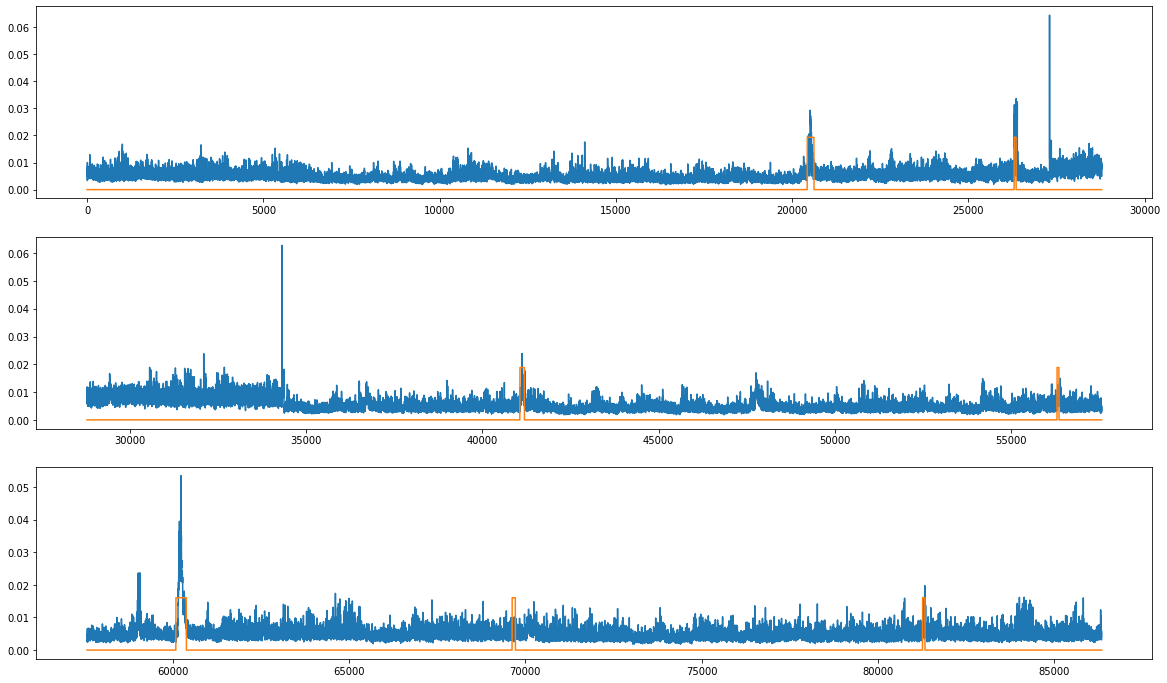

In [ ]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3)

# 데이터 후처리 

모델에서 출력된 anomaly score를 후처리를 진행해 noise나 튀는 값들을 smoothing을 진행해줍니다. 
##### 이를 통해서 주변 대비 너무 짧은 시간내로 값이 변동되는 부분을 제거해 모델의 최종 성능을 개선시킵니다. 

-------------------------
#### 최종 hyper-parameter 선정


- filter : butter filter with lowpass
- the order of the filer : 1 
- the ciritical frequency of the filter : 0.1 


In [ ]:
from scipy import signal
b, a = signal.butter(1, 0.1, btype='lowpass')

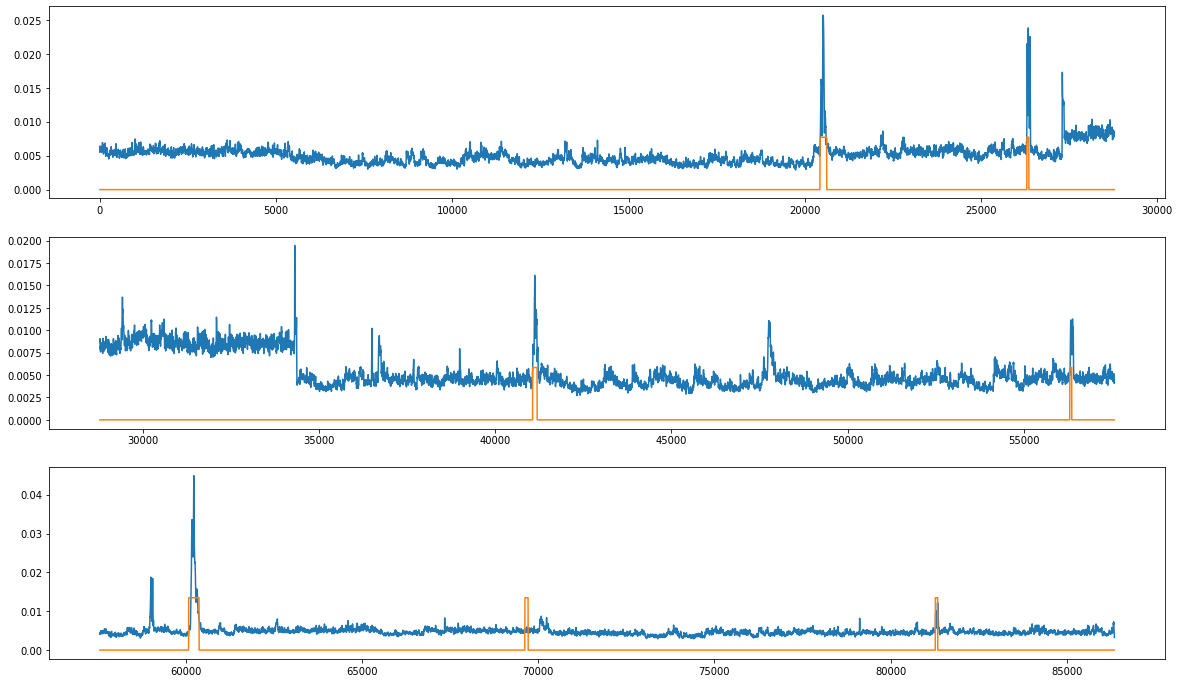

In [ ]:
check_graph(signal.filtfilt(b,a,ANOMALY_SCORE), CHECK_ATT, piece=3)

TaPR 점수 측정을 위해 ATTACK_LABEL을 생성

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

Lowpass가 적용된 smoothing의 anomaly score를 저장

In [ ]:
ANOMALY_SCORE_smooth = signal.filtfilt(b,a,ANOMALY_SCORE)

window 방식으로 추론이 진행됐기 때문에, 처음 시작 부분과 데이터셋 중간에 시간이 연속되지 않는 부분을 0으로 채워주기 위한 함수를 정의

In [ ]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label
    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []
    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

## Threshold 선정



---------------------------
#### 최종 Threshold 선정

- Threshold : 0.007599999999999999



- 선정이유 : 
    1. 다른 threshold 대비 위의 threshold가 public score를 가장 높음.
    2. 다른 threshold와 비교하였을 때 TaR과 TaP가 아주 미세하게 높음.


In [ ]:
for i in range(0,90):
    THRESHOLD = 0.009-i*0.0001
    LABELS = put_labels(ANOMALY_SCORE_smooth, THRESHOLD)
    FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
    TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
    print(f"Threshold : {THRESHOLD}")
    print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
    print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
    print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

Threshold : 0.007599999999999999  
F1: 0.399 (TaP: 0.265, TaR: 0.803)  
of detected anomalies: 6  
Detected anomalies: ['1', '2', '3', '4', '5', '7'] 

In [ ]:
 THRESHOLD = 0.007599999999999999 # threshold of final model that I attached . threshold must be adjust depending on every model

## 모델 테스트 데이터셋 검증

주어진 Test data를 이용해 모델의 성능을 평가합니다.

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(test_list)
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,0.399744,0.330391,0.498501,0.166913,0.536266,0.222300,0.0,0.0,0.0,0.699733,0.163355,0.0,0.251350,0.320025,0.585299,0.0,0.257818,0.346375,0.0,0.831111,0.410345,0.229845,0.389728,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016555,...,0.993484,1.0,0.0,0.928902,0.881604,0.0,0.007099,0.011171,0.0,0.393798,0.318115,0.138634,0.267816,0.420875,1.0,0.784722,0.0,0.0,0.013832,0.910736,0.095711,0.344340,0.0,0.281687,1.0,0.087231,0.345953,0.068729,0.213449,0.233826,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.471678,0.0,0.079812,0.499628,0.077046,0.429998,0.711769,0.0,0.0,0.0,0.410791,0.330391,0.401099,0.169598,0.536266,0.222988,0.0,0.0,0.0,0.699733,0.165362,0.0,0.268976,0.320597,0.592157,0.0,0.274666,0.362188,0.0,0.832458,0.407550,0.233744,0.354290,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016555,...,0.993484,1.0,0.0,0.932055,0.879826,0.0,0.006401,0.011733,0.0,0.411441,0.318115,0.138634,0.267816,0.518035,1.0,0.784722,0.0,0.0,0.013832,0.910736,0.096049,0.344340,0.0,0.286465,1.0,0.087721,0.348326,0.068729,0.213449,0.234697,0.377826,0.099579,0.285153,0.069240,0.404094,0.0,0.393961,0.0,0.0,0.173300
2,0.459304,0.0,0.079812,0.482713,0.077046,0.410346,0.711769,0.0,0.0,0.0,0.413946,0.330391,0.410774,0.172502,0.536266,0.223634,0.0,0.0,0.0,0.699733,0.165543,0.0,0.289090,0.320648,0.595666,0.0,0.296103,0.376145,0.0,0.831245,0.410068,0.230232,0.309968,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016080,...,0.993404,1.0,0.0,0.935463,0.878784,0.0,0.005820,0.009548,0.0,0.441153,0.318115,0.138634,0.267816,0.558917,1.0,0.784722,0.0,0.0,0.013099,0.910736,0.096612,0.344340,0.0,0.282161,1.0,0.089151,0.352068,0.066759,0.213449,0.236432,0.378191,0.103601,0.285153,0.068779,0.429462,0.0,0.393961,0.0,0.0,0.176731
3,0.458079,0.0,0.079812,0.478654,0.077046,0.408400,0.711769,0.0,0.0,0.0,0.416767,0.330391,0.411732,0.175448,0.536266,0.224574,0.0,0.0,0.0,0.699733,0.167548,0.0,0.305728,0.321219,0.602225,0.0,0.311816,0.395592,0.0,0.831124,0.414467,0.230656,0.305580,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016372,...,0.993476,1.0,0.0,0.938402,0.876919,0.0,0.005590,0.014363,0.0,0.465474,0.318115,0.138634,0.267816,0.562964,1.0,0.784722,0.0,0.0,0.012294,0.910736,0.097007,0.344340,0.0,0.282681,1.0,0.089169,0.352439,0.067969,0.213350,0.235499,0.379124,0.109204,0.285153,0.068734,0.461282,0.0,0.393961,0.0,0.0,0.178719
4,0.380719,0.0,0.079812,0.515098,0.077046,0.367874,0.711769,0.0,0.0,0.0,0.417601,0.330391,0.373615,0.167766,0.536266,0.224668,0.0,0.0,0.0,0.699733,0.167748,0.0,0.324030,0.318164,0.603747,0.0,0.330130,0.397535,0.0,0.831112,0.409374,0.232242,0.262319,0.0,0.285038,0.0,0.057660,0.0,0.0,0.016604,...,0.993483,1.0,0.0,0.919967,0.875853,0.0,0.005049,0.013167,0.0,0.478530,0.318115,0.138634,0.267816,0.594960,1.0,0.790972,0.0,0.0,0.011482,0.910736,0.097718,0.344340,0.0,0.284625,1.0,0.089170,0.347777,0.068934,0.213340,0.233437,0.379218,0.109763,0.285153,0.066761,0.472272,0.0,0.393961,0.0,0.0,0.182832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.511523,0.0,0.017216,0.516825,0.147339,0.557125,0.711717,0.0,0.0,0.0,0.642342,0.536139,0.593564,0.155617,0.395860,0.236017,0.0,0.0,0.0,0.812424,0.152317,0.0,0.361328,0.537054,0.068753,0.0,0.366699,0.324469,0.0,0.831096,0.517503,0.274012,0.648670,0.0,0.272795,0.0,0.060821,0.0,0.0,0.093953,...,0.183679,1.0,0.0,0.359874,0.036115,0.0,0.386987,0.624489,0.0,0.329

In [ ]:
print(boundary_check(TEST_DF))
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

(True, True, False)


  0%|          | 0/274749 [00:00<?, ?it/s]

# of valid windows: 274647


{'answer': tensor([0.3130, 0.0000, 0.0798, 0.5357, 0.1030, 0.3468, 0.7118, 0.0000, 0.0000,
         0.0000, 0.3671, 0.4218, 0.3648, 0.2459, 0.5363, 0.2733, 0.0000, 0.0000,
         0.0000, 0.6997, 0.2472, 0.0000, 0.5076, 0.2976, 0.0067, 0.0000, 0.5056,
         0.5927, 0.0000, 0.8326, 0.4024, 0.2742, 0.2948, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0188, 0.2841, 0.5347, 0.4334, 0.3560, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.0895, 0.8152, 0.0000, 0.7797, 0.0093,
         0.0000, 0.4634, 0.3181, 0.1386, 0.2678, 0.5014, 1.0000, 0.7847, 0.0000,
         0.0000, 0.8139, 0.9107, 0.1136, 0.3482, 0.0000, 0.3360, 1.0000, 0.1067,
         0.3418, 0.0781, 0.2542, 0.2711, 0.3713, 0.1660, 0.2852, 0.0771, 0.7258,
         0.0000, 0.3940, 0.0000, 0.0000, 0.0091]),
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4717, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1733],
         [0.4593, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1767],
      

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

CPU times: user 10.4 s, sys: 59 ms, total: 10.5 s
Wall time: 10.4 s


테스트 데이터셋 추론결과를 시각화 합니다. 이때, lowpass filter를 적용해 결과를 확인

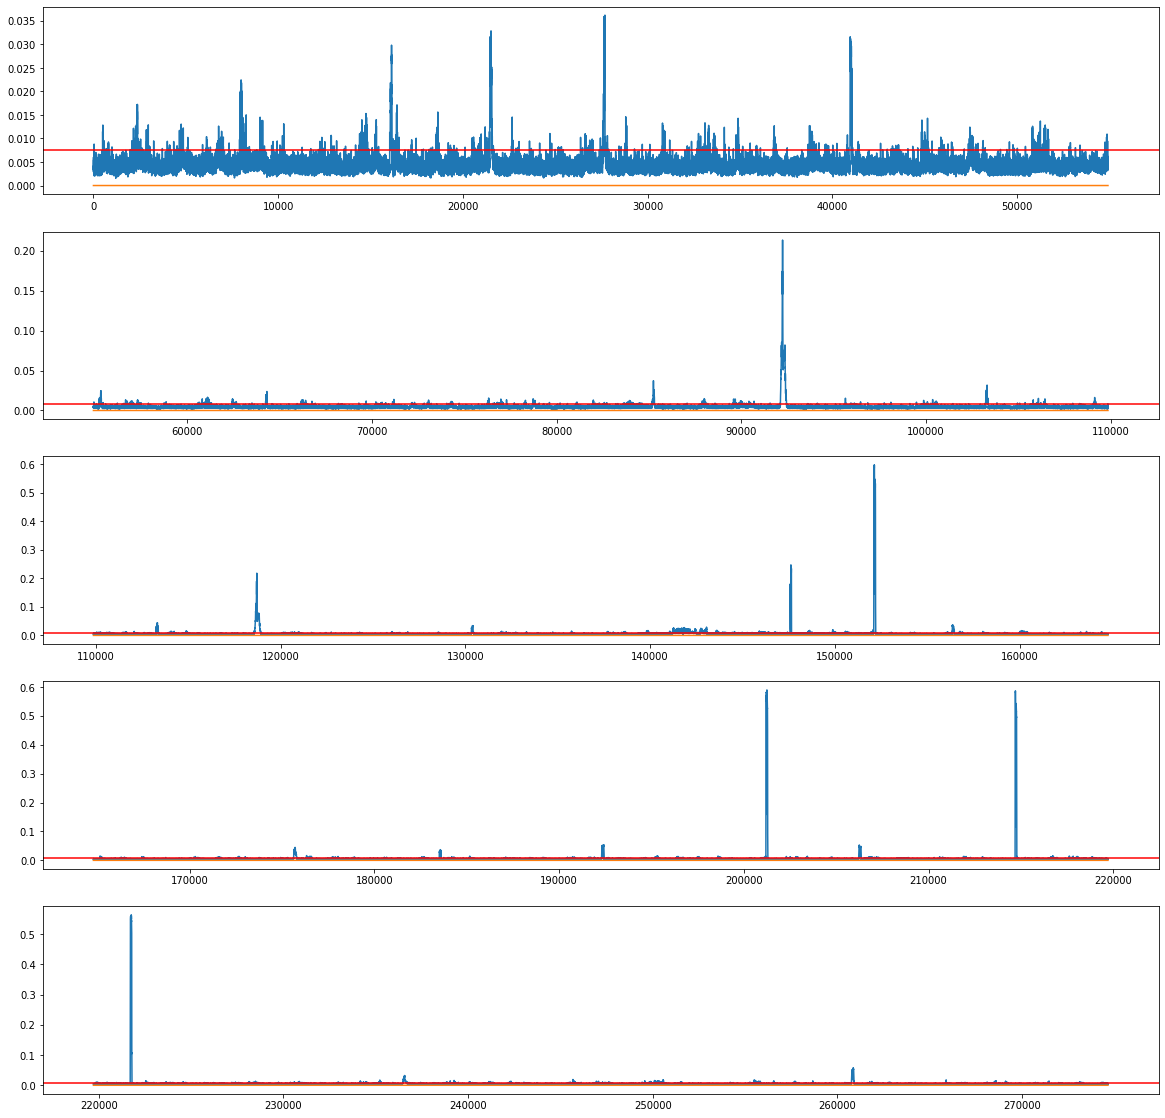

In [ ]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=5, THRESHOLD=THRESHOLD)

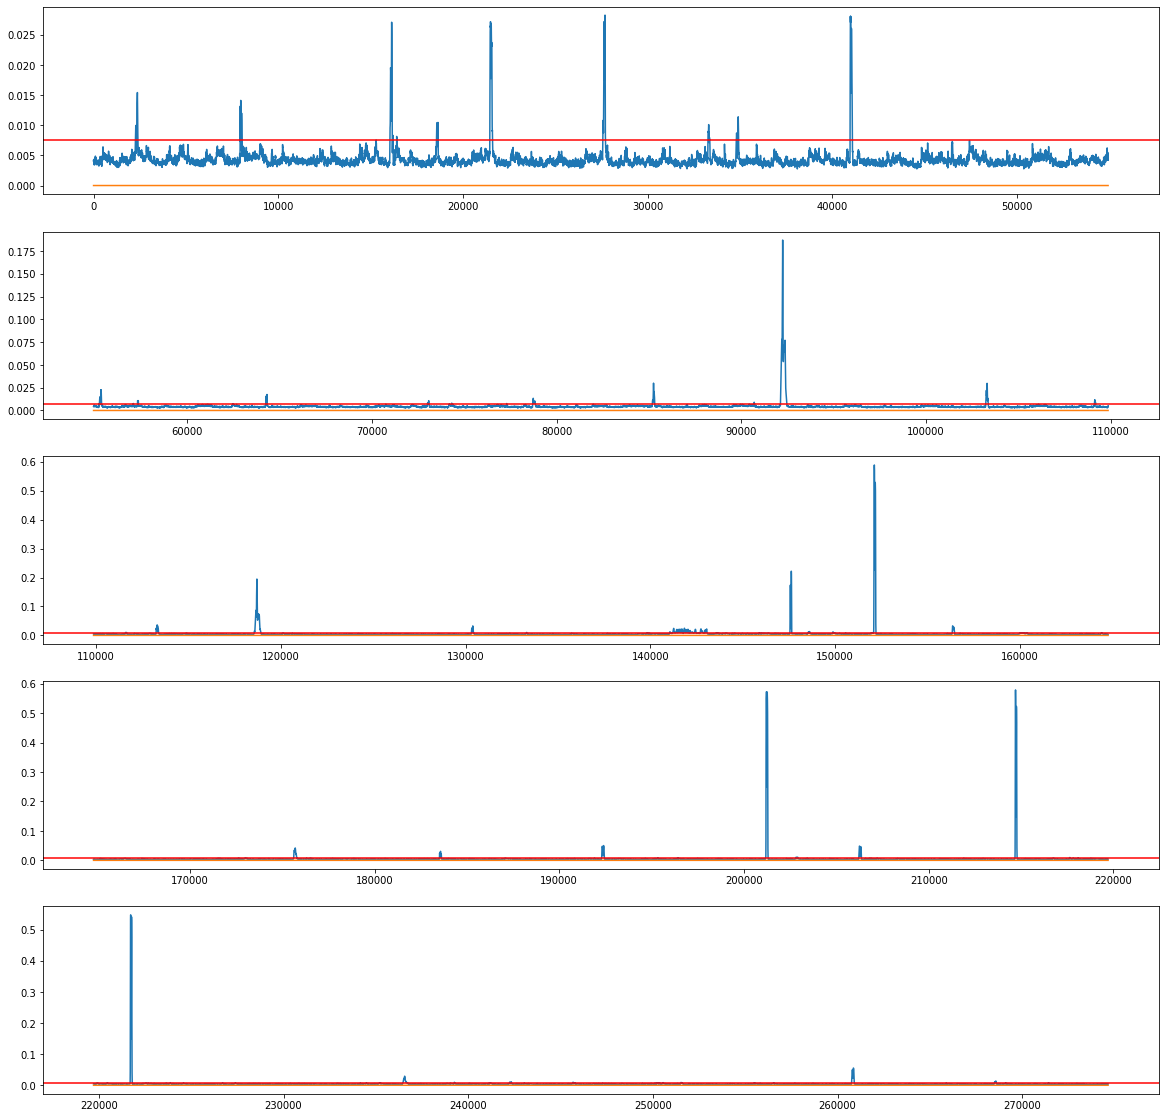

In [ ]:
check_graph(signal.filtfilt(b,a,ANOMALY_SCORE), CHECK_ATT, piece=5,THRESHOLD=THRESHOLD)

In [ ]:
THRESHOLD

0.007599999999999999

In [ ]:
ANOMALY_SCORE_smooth = signal.filtfilt(b,a,ANOMALY_SCORE)

In [ ]:
LABELS = put_labels(ANOMALY_SCORE_smooth, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274647,))

In [ ]:
np.sum(LABELS)

7431.0

## 최종 제출

In [ ]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission
submission = submission.reset_index(drop=True)
submission.to_csv(path + 'final_submission_52_70_399.csv', index=False)